**Student Name**: Maksim Karnaukh

**Student ID**: 20201604

# Lab 4: Monte Carlo Methods

### Instructions: **TODO** tags
In this lab, you will implement Monte Carlo methods. In particular, there will be 3 main steps:
1. **Policy Evaluation**: provided an arbitrary policy $\pi$, compute its value function $v_\pi$ using MC. You will be asked to compare your results to the exact solution you will find with Dynamic Programming.
2. **On-Policy MC Control**: implement MC to find an optimal soft policy, using an $\epsilon$-greedy policy.
3. **Off-Policy MC Control**: same idea using an $\epsilon$-greedy behavior policy and learning the optimal policy.

As usual, please *read* and *run* the notebook chronologically, and fill in the **TODO**s as you encounter them.
* <span style="color:blue"> Blue **TODOs** </span> means you have to implement the TODOs in the code.
* <span style="color:red"> Red **TODOs** </span> means you have to submit an explanation (of graph/results/theory).

At each section, <span style="color:green"> (xx points) </span> indicates the number of points of the entire section (labs are graded out of 10).


### Environment
Below are the libraries we will use and the Environment.

The Environment for this lab and the next lab on tabular RL is called the **Four Rooms** Environment. It simply contains 4 rooms of fixed size $5\times5$ in our case- in which the agent can move around, as in a house. There is no noise in the dynamics, meaning that the 4 directional actions deterministically take you to the requested neighboring state. Unless stated otherwise, the agent starts from the upper left corner. It will always have to reach the terminal state in the lower right corner to get a sparse reward of $+1$; any other transition gives reward $0$. A visualization will follow.

In [121]:
# -*- coding: utf-8 -*-
from __future__ import unicode_literals
import numpy as np
import gym
from gym import spaces
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as clr
from matplotlib import cm
import random
from copy import copy
import copy

In [122]:
class FourRoomsEnv(gym.Env):
    """ 
    Small Gridworld environment with 4 rooms.
    Starting up left, goal in lower-right.
    The main challenge is that the reward is sparse (1_goal)
    """

    def __init__(self, explo_starts=False, max_steps=None):
        self.roomsize = 5
        self.height = 2 * self.roomsize + 1  # +1 is obstacle width
        self.width = self.height
        half = self.width // 2  # shortcut
        quarter = half // 2  # shortcut
        self.gamma = 0.9
        self.t = 0
        self.max_steps = max_steps
        self.explo_starts = explo_starts
        self.action_space = spaces.Discrete(4)
        self.observation_space = spaces.Tuple((
            spaces.Discrete(self.height),
            spaces.Discrete(self.width)
        ))
        self.shapes = ((11, 11), 4)

        self.moves = {
            0: (-1, 0),  # up
            1: (0, 1),  # right
            2: (1, 0),  # down
            3: (0, -1),  # left
        }
        self.moves_to_str = {
            0: u'↑',
            1: u'→',
            2: u'↓',
            3: u'←',
        }

        self.terminal = (self.height - 1, self.width - 1)  # terminal state
        horizontal = [(i, half) for i in range(self.width)]
        vertical = [(half, i) for i in range(self.height)]
        self.obstacles = horizontal + vertical
        # now opening the 4 passages
        for state in [(quarter, half), (half, quarter), (half, self.height - quarter), (self.height - quarter, half)]:
            self.obstacles.remove(state)
        self.start = (0, 0)
        self.s = None
        # begin in start state
        self.reset()

    def reset(self):
        if self.max_steps is not None:
            self.t = 0
        if self.explo_starts:
            while True:
                s = self.observation_space.sample()
                if s not in self.obstacles + [self.terminal]:
                    break
            self.s = s
            #print("Random Start at S={}".format(s))

        else:
            self.s = self.start
        return self.s

    def step(self, action):
        """ Moves the agent in the action direction."""
        # Next, moving according to action
        x, y = self.moves[action]
        if (self.s[0] + x, self.s[1] + y) not in self.obstacles:
            # move is allowed
            self.s = self.s[0] + x, self.s[1] + y

            # Finally, setting the agent back into the grid if fallen out
            self.s = (max(0, self.s[0]), max(0, self.s[1]))
            self.s = (min(self.s[0], self.height - 1),
                      min(self.s[1], self.width - 1))

        self.t += 1
        done_goal = (self.s == self.terminal)
        done = done_goal
        if self.max_steps is not None and self.t == self.max_steps:
            done = True
            self.t = 0
        return self.s, int(done_goal), done, {}

    def is_terminal(self, state):
        return state == self.terminal

    def p(self, state, action):
        assert not self.is_terminal(state)
        self.s = state
        next_state, reward, done, info = self.step(action)
        return {(next_state, reward): 1}

    def states(self):
        ss = []
        for i in range(self.height):
            for j in range(self.width):
                if (i, j) not in self.obstacles:
                    ss.append((i, j))
        return ss

    def plot_values_policy(self, values, policy, plot_all_policy=False, cbar=True):
        """ Visualizes a policy and value function given an agent with V and policy."""
        fig, ax = plt.subplots()
        values[tuple(zip(*self.obstacles))] = None  # -1
        cmap = copy.copy(cm.get_cmap("RdYlGn"))
        # modify colormap
        l = np.array([cmap(i) for i in range(cmap.N)]).T
        l[0:2] = np.clip(l[0:2], 0, 0.9)
        l[2] = np.clip(l[2], 0, 0.25)
        l = l.T
        my_cmap = matplotlib.colors.ListedColormap(l, name='nani')
        my_cmap.set_bad('black')

        im = ax.imshow(values, cmap=my_cmap)
        for i in range(self.height):
            for j in range(self.width):
                s = (i, j)
                if s not in self.obstacles:
                    t = self.moves_to_str[policy[s]] if not self.is_terminal(s) \
                                                        and ((values[s] != 0) or (plot_all_policy)) else ""
                    text = ax.text(j, i, t,
                                   ha="center", va="center", color="w", fontsize=15)

        ax.set_title("Value function and Policy visualization")
        fig.tight_layout()
        if cbar:
            plt.colorbar(im)
        plt.show()

## 1. <span style="color:green"> (5 points) </span>  Policy Evaluation

### 1.1 Defining and visualizing the policy
Let's define and visualize an arbitrary *deterministic* policy $\pi$. We're picking a deterministic policy for ease of visualization and understanding of the learning process. 

Since we know we only need to go south and east to solve the task, let's use a policy that only picks between these two. We're plotting in green the terminal state we want to reach; later, the colors will correspond to state values. The dark squares correspond to walls.

C:\Users\Maksim Karnaukh\AppData\Local\Temp\ipykernel_14164\3400520055.py:107: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy.copy(cm.get_cmap("RdYlGn"))


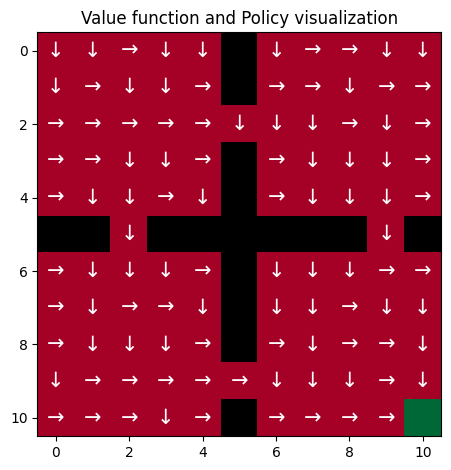

In [123]:
# Defining the environment
np.random.seed(54)
env = FourRoomsEnv()
# Defining the policy
pi = {s: np.random.choice([1, 2]) for s in env.states()}
# Visualizing the environment and policy
zero_values = np.zeros(env.shapes[0])
zero_values[env.terminal] = 1
env.plot_values_policy(zero_values, pi, plot_all_policy=True, cbar=False)
np.random.seed(None)

### 1.2. <span style="color:blue"> **TODO** </span> DP Policy Evaluation
We want to evaluate $v_\pi$ for this policy. Note that we could also compute $q_\pi$, it doesn't really matter if we're not looking to extend to control!

We will first use what we know works, i.e., **Dynamic Programming**'s Policy Evaluation, then implement Monte Carlo to compare the results.

- <span style="color:blue"> **TODOs** </span>: Implement **DP_PolicyEvaluation**. This will be similar to the Policy and Value Iteration agents from the previous lab, we're providing an MDP as input and implement a `run` method to compute the values. Instead of a dictionary as before, we will now use a **numpy array** to store the $v$ and $q$ from now on, as it is more efficient, more fit for this environment, and easier to visualize. The policy $\pi$ is a dictionary here, but it makes little practical difference. You can use an In-Place algo, or not, however you want.

In [124]:
class DP_PolicyEvaluation():
    def __init__(self, mdp):
        self.mdp = mdp
        self.gamma = self.mdp.gamma
        self.V = np.zeros(self.mdp.shapes[0])

    def inf_norm(self, v1, v2):
        # v1 and v2 are 2d numpy arrays
        return np.max(np.abs(v1 - v2))

    def run(self, pi, delta):
        """ Runs Policy evaluation for a given policy. 
        No returns expected, but use the self.V array to store your values so we can plot it.
        Parameters
        ----------
        pi: dict
            Policy to Evaluate. Comes as a dictionary of state:action keys.
        delta: float
            Precision at which Policy Evaluation should be stopped.
        """
        # DONE: Implement the run method.
        non_terminal_states = [s for s in self.mdp.states() if not self.mdp.is_terminal(s)]
        previous_V = copy.deepcopy(self.V)
        while True:
            for s in non_terminal_states:
                self.V[s] = sum([p * (r + self.gamma * self.V[s_]) for (s_, r), p in self.mdp.p(s, pi[s]).items()])
            if self.inf_norm(self.V, previous_V) < delta:
                break
            previous_V = copy.deepcopy(self.V)


Let's run the Policy Evaluation and visualize the estimated values of $\pi$:

C:\Users\Maksim Karnaukh\AppData\Local\Temp\ipykernel_14164\3400520055.py:107: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy.copy(cm.get_cmap("RdYlGn"))


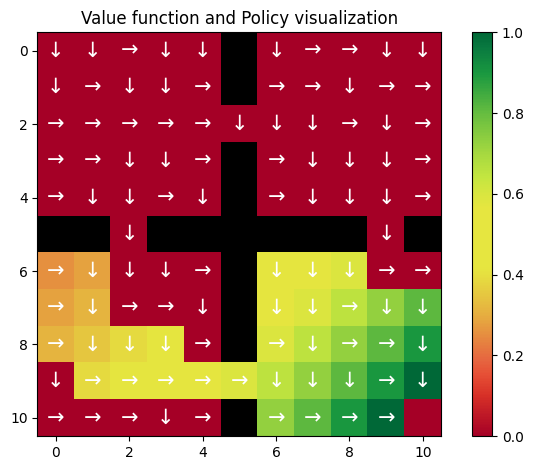

In [125]:
agent_dp = DP_PolicyEvaluation(env)
agent_dp.run(pi, delta=1e-3)
env.plot_values_policy(agent_dp.V, pi, plot_all_policy=True)

<span style="color:red"> **TODO** </span>: Shortly **comment** your result.

We see that the closer we get to the terminal state (bottom right), the higher the value (terminal state has reward +1). We also see that all colored states (with value > 0) can from themselves reach (if you follow the policy (arrows)) the terminal state. For the red states this is not the case.

### 1.2.  <span style="color:blue"> **TODO** </span> Monte Carlo Policy Evaluation

We will now find $v_\pi$ simply by interacting with the environment, using MC. We will need a different `argmax` function from the one in the `numpy` library, because it always returns the first occurence of the max, while we need a random choice of the occurences. 

In [126]:
# Nothing to do in this cell.
def allmax(a):
    """ Returns all occurences of the max """
    if len(a) == 0:
        return []
    all_ = [0]
    max_ = a[0]
    for i in range(1, len(a)):
        if a[i] > max_:
            all_ = [i]
            max_ = a[i]
        elif a[i] == max_:
            all_.append(i)
    return all_


def my_argmax(v):
    """ Breaks ties randomly. """
    return random.choice(allmax(v))

From here on, we are shifting from the Dynamic Programming framework to the more general Reinforcement Learning framework of **Agent-Environment interactions**. Our abstraction for such agents is that they need to be able to `act` given a state, i.e., sample from their policy; and `learn` given a transition $\left(s,a,r,s^\prime\right)$. For practical purposes, we also need to `reset` the agent to $0$ learning, getting ready for another round of learning; similar to the Environment's `reset` method, getting ready for a new episode.

- <span style="color:red"> **TODO** </span>: **Remind** why MC Policy Evaluation should converge? <br/> 
By the law of large numbers, the sequence of averages of the estimates of $v_{\pi}(s)$ (we are averaging the returns of each state s, where each return is independent) converges to their expected value (as the number of (first) visits to s goes to infinity).
$V(s) \rightarrow v_{\pi}(s)$ as the number of visits to s goes to infinity.

- <span style="color:blue"> **TODO** </span>: **Implement** MC Policy Evaluation provided the policy $\pi$ we have already evaluated. The policy is now given to the agent as we build it (in `__init__`), since we want the agent to interact using it. Please use `self.V` to store your state value estimates.

In [127]:
class MonteCarloPolicyEval():
    """ Given a policy, uses that policy to act in the environment.
    Learns its V value.
    """

    def __init__(self, env_shapes, pi, epsilon=0.1, gamma=0.9, **kwargs):
        if env_shapes is not None:  # otherwise, bandits
            self.input_shape, self.n_actions = env_shapes

        self.gamma = gamma
        self.epsilon = epsilon
        self.V = np.zeros(self.input_shape)  # Array of value estimates.
        self.pi = pi
        # You can add or remove things in here, if needed
        self.returns = np.zeros(self.input_shape)  # G
        self.occurences = np.zeros(self.input_shape)  # N
        self.state_action_time_index = np.zeros(self.input_shape, dtype=int)  # to keep track of first visits
        self.trajectory = []

    def reset(self):
        """ 
        Reset method of your Agent. No inputs, no returns.
        """
        # DONE: Reset your agent. 
        self.V = np.zeros(self.input_shape)
        self.returns = np.zeros(self.input_shape)
        self.occurences = np.zeros(self.input_shape)
        self.state_action_time_index = np.zeros(self.input_shape, dtype=int)

    def act(self, s):
        """ Action in the environment, i.e. sample from our policy.
        Parameters
        ----------
        s: tuple
            State from which to give out an action
        Returns
        -------
        action : int
            Action to perform in the env
        """
        # DONE: act
        return self.pi[s]

    def learn(self, s, a, r, s_, d=False):
        """ MC learning the policy value from a transition. 
        Parameters
        ----------
        s, a, r, s_, d: tuple, int, float, tuple, bool
            Transition in the environment.
            From state s, taking action a, obtaining reward r and ending up in state s_
            d is the done signal, indicating if s_ is terminal.
        """
        # DONE: implement the learning of the MonteCarloPolicyEval agent
        self.trajectory.append((s, a, r)) 
        if d:            
            for i in range(len(self.trajectory)): # to know the first visit of each state
                self.state_action_time_index[self.trajectory[i][0]] += 1
                
            G = 0
            for i in range(len(self.trajectory) - 1, -1, -1):  # for each state visited during the episode
                G = self.gamma * G + self.trajectory[i][2]
                s = self.trajectory[i][0]  # current state in for loop
                if self.state_action_time_index[s] == 1:  # first visit MC
                    self.returns[s] += G  # increment total return
                    self.occurences[s] += 1  # increment counter
                    self.V[s] = self.returns[s] / self.occurences[s]  # update estimate
                else:
                    self.state_action_time_index[s] -= 1
            self.trajectory = []
            self.state_action_time_index = np.zeros(self.input_shape, dtype=int)


Now we can implement our first true learning loop! Using the [gym](https://gym.openai.com/) framework again for agent-env interactions, here's how we expect a learning loop to look like for a single episode:
```
state = env.reset()
while True:
  action = agent.act()
  next_state, reward, done, info = env.step(action)
  agent.learn(state, action, reward, next_state, done)

  if done:
    break
env.close()
```

This is what is implemented below, with a bit more to plot things out.

In [128]:
# Learning and visualization. Nothing to do here.
def learn_v_pi(agent, env, n_episodes):
    evaluations_history = []
    agent.reset()
    first = True
    # Training phase
    for ep in range(n_episodes):
        s = env.reset()
        while True:  # step limit implemented in Env
            action = agent.act(s)  # must be = pi[s]
            s_, reward, done, info = env.step(action)
            agent.learn(s, action, reward, s_, done)
            if done:
                break
            s = s_
        if first and np.any(agent.V != 0):
            print("V visualization after the first rewarding episode observed - episode {}:".format(ep))
            env.plot_values_policy(agent.V, agent.pi, plot_all_policy=True)
            first = False
        if not first and not ep % 200:
            print("V visualization after episode {}:".format(ep))
            env.plot_values_policy(agent.V, agent.pi, plot_all_policy=True)

    print("Final V visualization: ")
    env.plot_values_policy(agent.V, agent.pi, plot_all_policy=True)
    env.close()

Since we chose a deterministic policy, we actually only need Exploring Starts to go over every single state once in order to get a perfect estimate. However, we will proceed as if $\pi$ was not deterministic, and without assuming control over the initial states - we know they are random, but no more.

We need all states to be sampled. Since there are around $100$ non-terminal states, we can be sure that all will most likely have been selected once if we run $1000$ episodes.

V visualization after the first rewarding episode observed - episode 2:


C:\Users\Maksim Karnaukh\AppData\Local\Temp\ipykernel_14164\3400520055.py:107: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy.copy(cm.get_cmap("RdYlGn"))


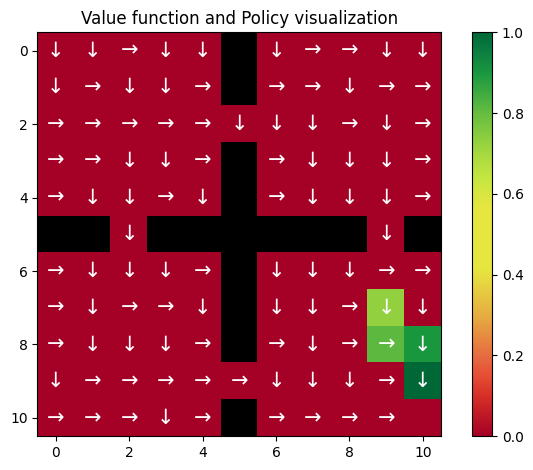

V visualization after episode 200:


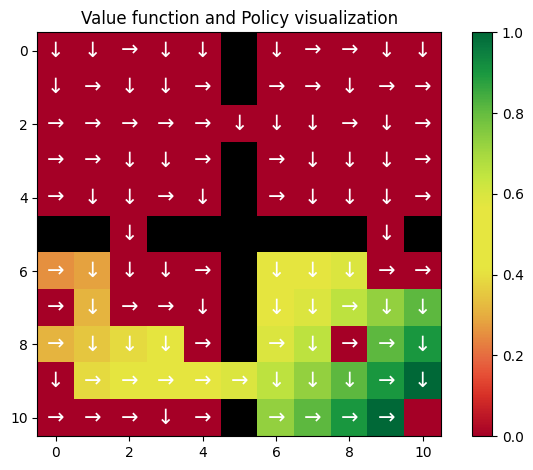

V visualization after episode 400:


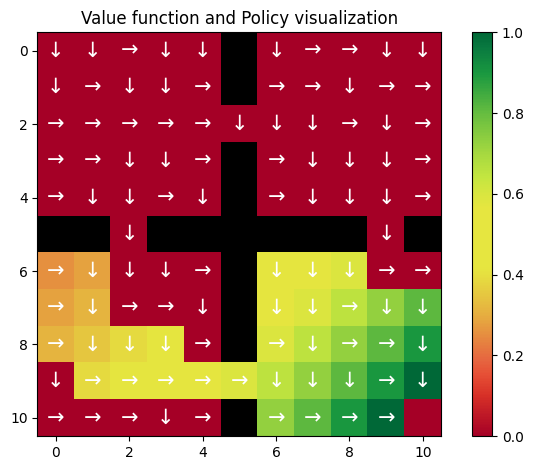

V visualization after episode 600:


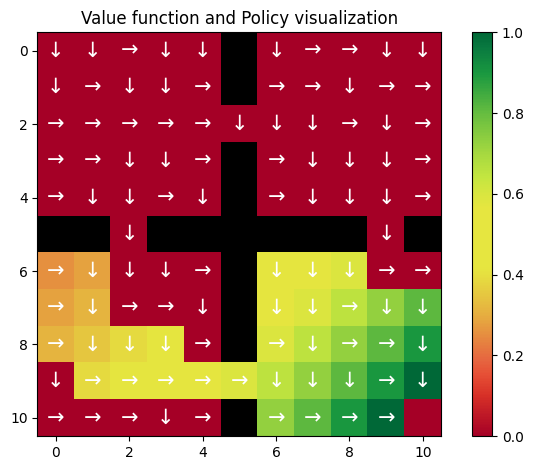

V visualization after episode 800:


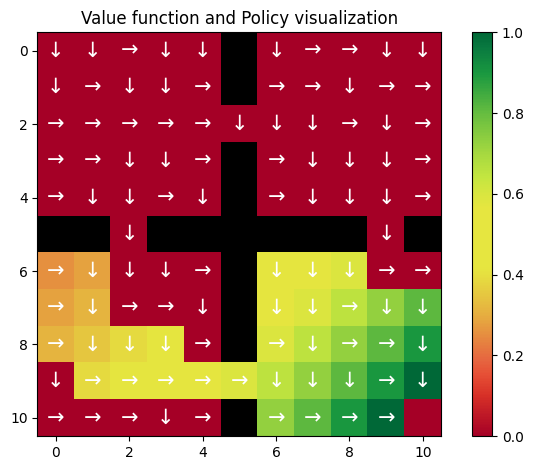

Final V visualization: 


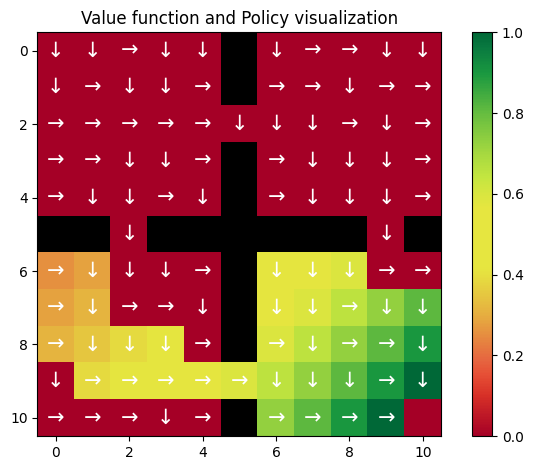

In [129]:
env = FourRoomsEnv(explo_starts=True, max_steps=50)
shapes = (tuple([env.observation_space[i].n for i in range(len(env.observation_space))]), env.action_space.n)
d = {
    'env_shapes': shapes,
    'epsilon': 0.2,
    'gamma': env.gamma,
    'pi': pi
}
agent_mc = MonteCarloPolicyEval(**d)
learn_v_pi(agent_mc, env, 1000)

Reminder, to compare with your DP solution:

C:\Users\Maksim Karnaukh\AppData\Local\Temp\ipykernel_14164\3400520055.py:107: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy.copy(cm.get_cmap("RdYlGn"))


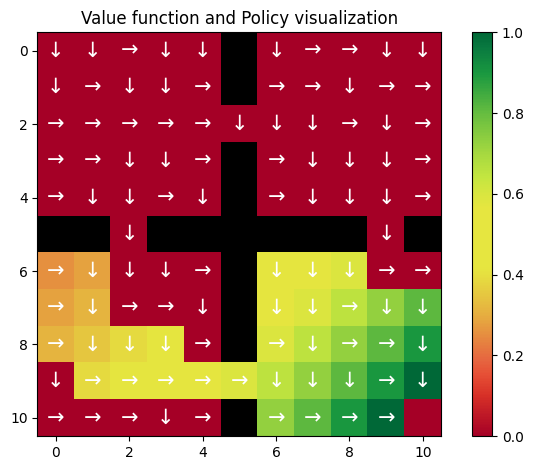

In [130]:
env.plot_values_policy(agent_dp.V, pi, plot_all_policy=True)

<span style="color:red"> **TODO** </span>: Shortly **compare** your results and the methods.

After more and more episodes, the results become more the same as the DP solution. The (final) results are the same if my eyes serve me correctly. Contrary to DP, MC does not need to know the dynamics of the environment (mdp model). It updates the value estimates based on observed returns (see above) from entire episodes.

## 2. <span style="color:green"> (5 points) </span>  Monte Carlo Control
### 2.1. <span style="color:blue"> **TODO** </span> On-Policy MC
Policy Evaluation is cool, but the most interesting problem to solve is the Control problem, where we need to find an optimal policy. However, we drastically changed the framework: from perfect access to the MDP dynamics, we now want to learn an optimal policy only from Agent-Environment interactions.

- <span style="color:red"> **TODO** </span> **Remind** how MC approaches the Control problem to converge. <br/> 
We use the idea of General Policy Iteration (GPI) to converge to the optimal policy. We alternate between policy evaluation and policy improvement. We use MC to evaluate the policy and then improve it by making it greedy with respect to the current action value function. We then evaluate the new policy and so on. This process converges to the optimal policy and action-value function.

- <span style="color:red"> **TODO** </span> **Remind** how on-policy MC works *without exploring starts*.<br/> 
The overall idea of On-policy MC without exploring starts is still that of GPI. Here, we use a stochastic policy to ensure enough exploration, we move the policy towards an epsilon-greedy policy. 

- <span style="color:blue"> **TODO** </span> **Implement** $\epsilon$-greedy MC for on-policy Control.

In [131]:
class EGMonteCarlo():
    """ Tabular method that keeps the Q-values of all the possible
    state-action pairs; updates on an episode-wise schedule
    On-Policy version using epsilon-greedy
    """

    def __init__(self, env_shapes, epsilon=0.1, gamma=0.9, **kwargs):
        if env_shapes is not None:  # otherwise, bandits
            self.input_shape, self.n_actions = env_shapes
        self.gamma = gamma
        self.epsilon = epsilon

        self.Q = np.zeros((*self.input_shape,
                           self.n_actions))  # Q value estimates. Access a state with Q[s] and state action pair with Q[s][a]
        self.returns = {(i, j): [[] for _ in range(self.n_actions)] for i in range(self.input_shape[0]) for j in
                        range(self.input_shape[1])}
        self.pi = np.full((*self.input_shape, self.n_actions), 1 / self.n_actions)
        self.state_action_time_index = np.zeros((*self.input_shape, self.n_actions),
                                                dtype=int)  # to keep track of first visits
        self.trajectory = []

        self.reset()

    def reset(self):
        self.Q = np.zeros((*self.input_shape, self.n_actions))
        self.returns = {(i, j): [[] for _ in range(self.n_actions)] for i in range(self.input_shape[0]) for j in
                        range(self.input_shape[1])}
        self.pi = np.full((*self.input_shape, self.n_actions), 1 / self.n_actions)
        self.state_action_time_index = np.zeros((*self.input_shape, self.n_actions), dtype=int)
        self.trajectory = []

    def act(self, s):
        # a_star = my_argmax(self.Q[s])
        # if np.random.rand() < self.epsilon:
        #     return np.random.choice([i for i in range(self.n_actions) if i != a_star])
        # else:
        #     return my_argmax(self.Q[s])
        return np.random.choice(range(self.n_actions), p=self.pi[s])

    def learn(self, s, a, r, s_, d=False):
        self.trajectory.append((s, a, r))
        if d:
            for i in range(len(self.trajectory)):
                self.state_action_time_index[self.trajectory[i][0]][self.trajectory[i][1]] += 1

            G = 0
            for i in range(len(self.trajectory) - 1, -1, -1):  # for each state visited during the episode
                G = self.gamma * G + self.trajectory[i][2]
                s = self.trajectory[i][0]  # current state in for loop
                a = self.trajectory[i][1]  # current action in for loop
                if self.state_action_time_index[s][a] == 1:  # first visit MC
                    self.returns[s][a].append(G)  # increment total return
                    self.Q[s][a] = np.mean(self.returns[s][a])  # update estimate
                    A_star = my_argmax(self.Q[s])
                    for a_ in range(self.n_actions):
                        if a_ == A_star:
                            self.pi[s][a_] = 1 - self.epsilon + self.epsilon / self.n_actions
                        else:
                            self.pi[s][a_] = self.epsilon / self.n_actions
                else:
                    self.state_action_time_index[s][a] -= 1
            self.trajectory = []
            self.state_action_time_index = np.zeros((*self.input_shape, self.n_actions), dtype=int)

In [132]:
def view_train_agent(agent, env, n_episodes):
    """ Returns the steps_history of the agent"""
    evaluations_history = []
    view = [0, 1, 3, 5, 10, 100, 500]
    agent.reset()
    # Training phase
    steps_history = np.empty(n_episodes)
    for ep in range(n_episodes):
        t = 0
        s = env.reset()
        while True:
            action = agent.act(s)
            s_, reward, done, info = env.step(action)
            agent.learn(s, action, reward, s_, done)
            if done:
                break
            s = s_
            t += 1
        if ep in view:
            print("Best Q and action after episode {}:".format(ep))
            best_qs = np.max(agent.Q, axis=-1)
            greedy_policy = np.argmax(agent.Q, axis=-1)
            env.plot_values_policy(best_qs, greedy_policy)

        steps_history[ep] = t

    print("Final Q and policy:")
    best_qs = np.max(agent.Q, axis=-1)
    greedy_policy = np.argmax(agent.Q, axis=-1)
    env.plot_values_policy(best_qs, greedy_policy)
    env.close()
    return steps_history[1:]  # First is totally random

Since there is now stochastic exploration, the episodes will all reach the terminal state, if given enough time. We can remove both the step limit and Exploring Starts.

Best Q and action after episode 0:


C:\Users\Maksim Karnaukh\AppData\Local\Temp\ipykernel_14164\3400520055.py:107: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy.copy(cm.get_cmap("RdYlGn"))


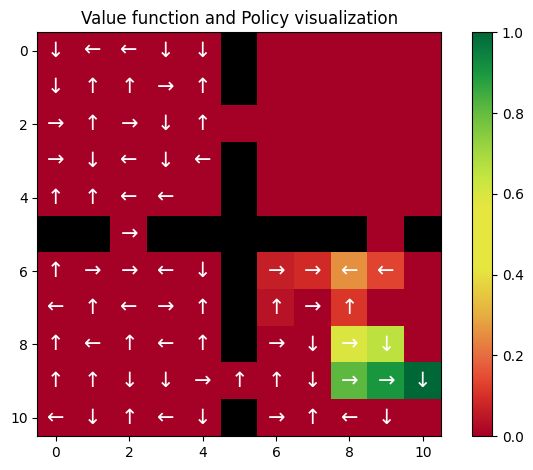

Best Q and action after episode 1:


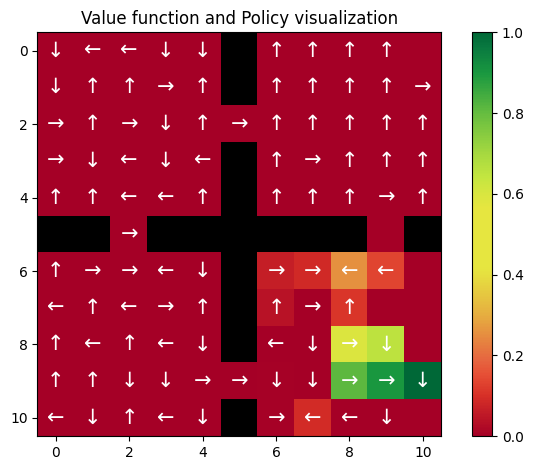

Best Q and action after episode 3:


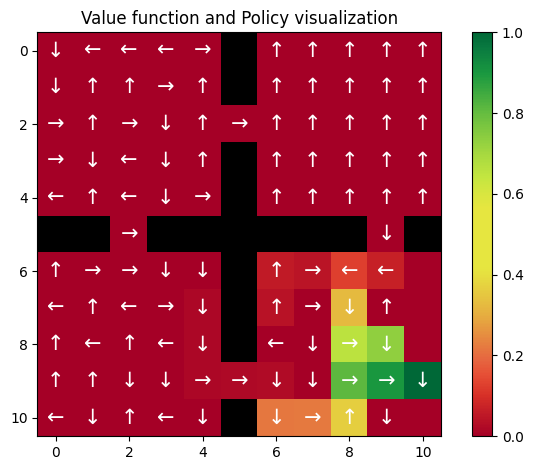

Best Q and action after episode 5:


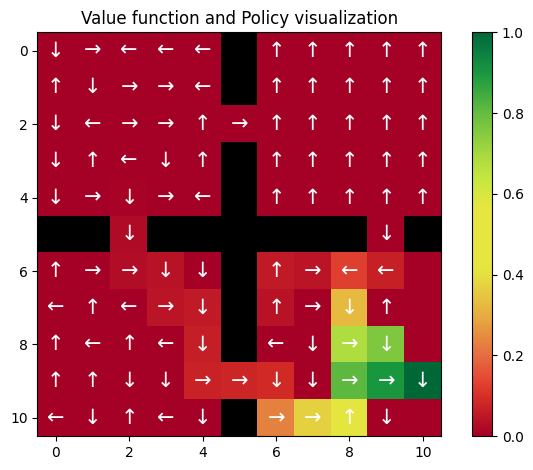

Best Q and action after episode 10:


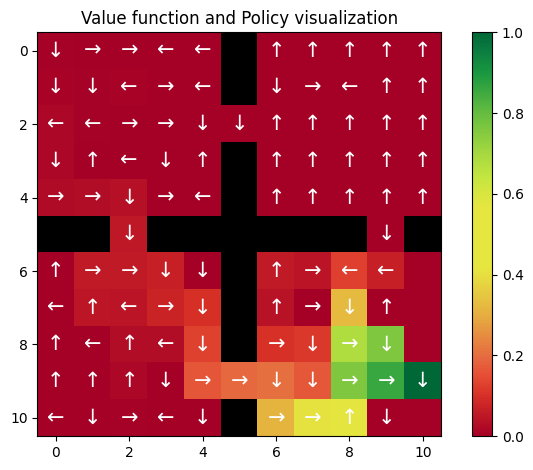

Best Q and action after episode 100:


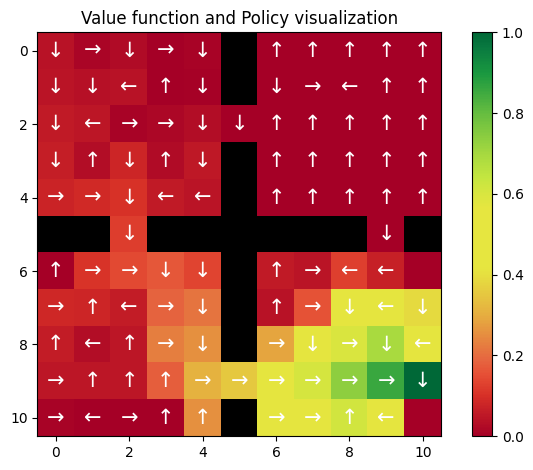

Best Q and action after episode 500:


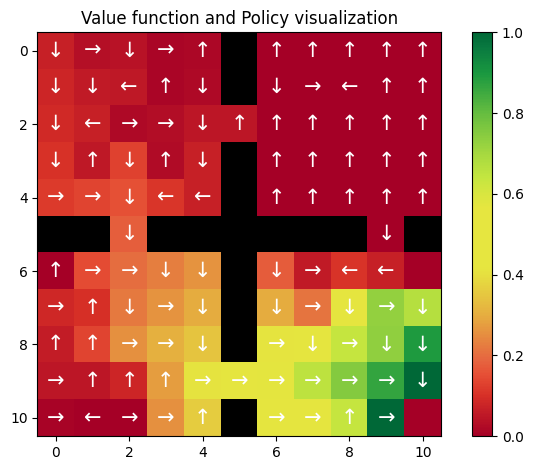

Final Q and policy:


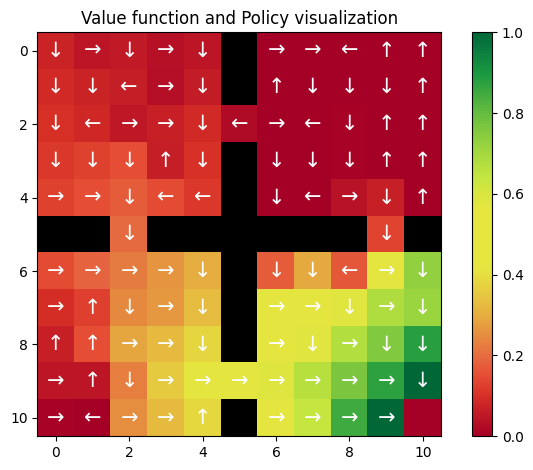

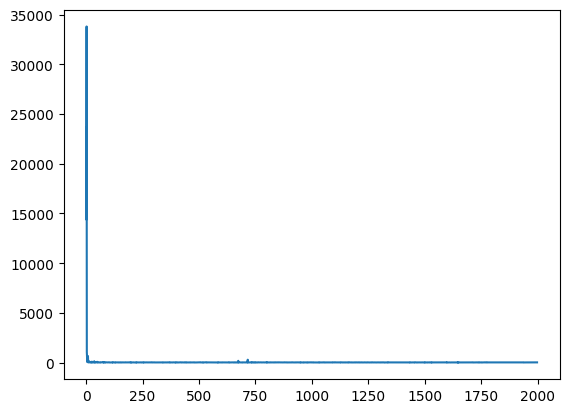

In [133]:
env = FourRoomsEnv()
shapes = (tuple([env.observation_space[i].n for i in range(len(env.observation_space))]), env.action_space.n)
d = {
    'env_shapes': shapes,
    'epsilon': 0.2,
    'gamma': env.gamma,
}
agent = EGMonteCarlo(**d)
perf_EG = view_train_agent(agent, env, 2000)
plt.plot(perf_EG)

<span style="color:red"> **TODO** </span>: **Explain** your understanding of how MC updates its values.**Comment** the results you obtained and the evolution of the learnt policy.

If we are talking about just the general way in the algorithm for the action-values: 
After each whole episode, we first calculate the return G (sum of discounted rewards from the current time step to the end of the episode) for each time step. Then we update the Q value of each state-action pair by averaging the returns we have observed for that pair. 
$Q(S_{t}, A_{t}) = average(Returns(S_{t}, A_{t})) = \frac{\text{sum of returns for } (S_{t}, A_{t})}{\text{number of times } (S_{t}, A_{t}) \text{ occured}}$.

Updating state-value estimates happens in a similar manner (see one of the first TODOs in this lab, in the code).

As for the results, we see that after more and more episodes, the state policies (directions) become better (they get higher chance of being selected because of higher action-values, and lead to the terminal state in less total steps). 
The number of steps to reach the terminal state decreases a lot after the first few episodes, while it is very high in the beginning. We can see how the rewards are propagated through the environment and we can see the 'path' that forms.

Sometimes (if we run this multiple times) we still see some peak(s) in the graph in the number of steps to reach the terminal state, but this is normal. It is because of the exploration. The agent might have found a better policy, but it still needs to explore to find the optimal policy (this happens because of the epsilon).

## 2.2. <span style="color:blue"> **TODO** </span> Off-Policy Monte Carlo
On-Policy Monte Carlo without Exploring starts is limited to soft policies. Off-Policy MC offers the promise of learning an optimal policy -and optimal values- by using a behavior policy $b$ different from the learnt policy $\pi$. In our case, we will follow the course and choose $b$ to be an $\epsilon$-greedy policy according to our $Q$ estimates, while the learnt $\pi$ policy is the true optimal policy.
- <span style="color:blue"> **TODO** </span> **Implement** MC for Off-policy Control as discussed. Use the same formalism as the On-Policy agent above.

In [134]:
class OffMonteCarloIS(EGMonteCarlo):

    def __init__(self, env_shapes, epsilon=0.1, gamma=0.9, **kwargs):
        super().__init__(env_shapes, epsilon, gamma, **kwargs)
        self.b = np.full((*self.input_shape, self.n_actions), 1/self.n_actions)
        self.C = np.zeros((*self.input_shape, self.n_actions))
        # deterministic policy now
        self.pi = {s: np.argmax(self.Q[s]) for s in [(i, j) for i in range(self.input_shape[0]) for j in range(self.input_shape[1])]}

    def reset(self):
        super().reset()
        self.b = np.full((*self.input_shape, self.n_actions), 1/self.n_actions)
        
    def act(self, s):
        return np.random.choice(range(self.n_actions), p=self.b[s])
        
    def learn(self, s, a, r, s_, d=False):
        self.trajectory.append((s, a, r))
        if d:
            for i in range(len(self.trajectory)):
                self.state_action_time_index[self.trajectory[i][0]][self.trajectory[i][1]] += 1

            G = 0
            W = 1
            for i in range(len(self.trajectory) - 1, -1, -1):  # for each state visited during the episode
                G = self.gamma * G + self.trajectory[i][2]
                s = self.trajectory[i][0]  # current state in for loop
                a = self.trajectory[i][1]  # current action in for loop
                self.C[s][a] += W
                self.Q[s][a] += (W / self.C[s][a]) * (G - self.Q[s][a])
                A_star = np.argmax(self.Q[s])
                self.pi[s] = A_star
                if a != A_star:
                    break
                W *= 1 / self.b[s][a]
            self.trajectory = []
            self.state_action_time_index = np.zeros((*self.input_shape, self.n_actions), dtype=int)
            for s in [(i, j) for i in range(self.input_shape[0]) for j in range(self.input_shape[1])]:
                argmax = my_argmax(self.Q[s])
                for a in range(self.n_actions):
                    if a == argmax:
                        self.b[s][a] = 1 - self.epsilon + self.epsilon / self.n_actions
                    else:
                        self.b[s][a] = self.epsilon / self.n_actions
                

Best Q and action after episode 0:


C:\Users\Maksim Karnaukh\AppData\Local\Temp\ipykernel_14164\3400520055.py:107: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy.copy(cm.get_cmap("RdYlGn"))


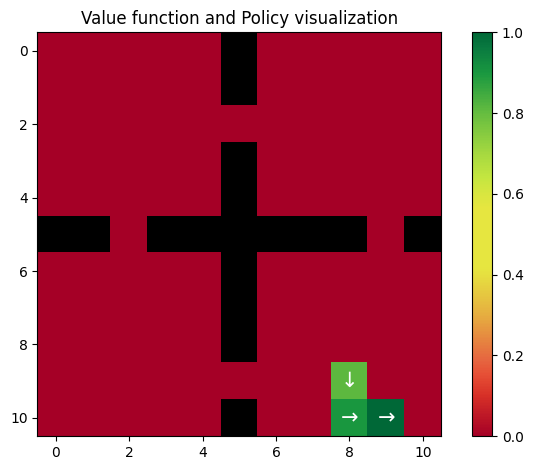

Best Q and action after episode 1:


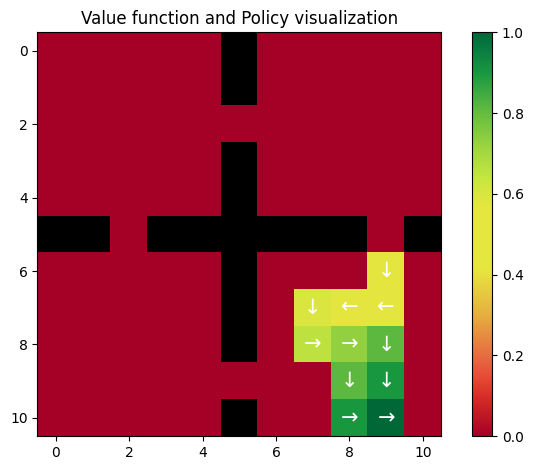

Best Q and action after episode 3:


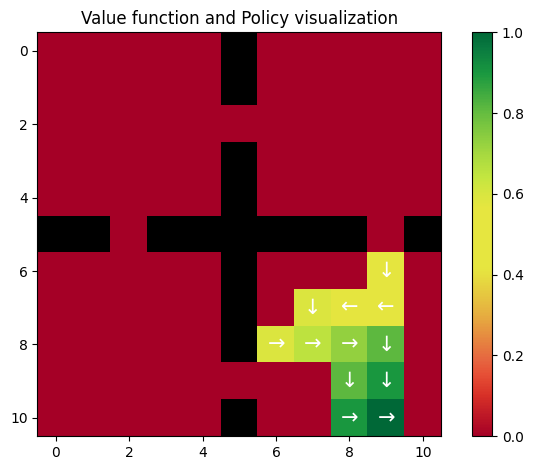

Best Q and action after episode 5:


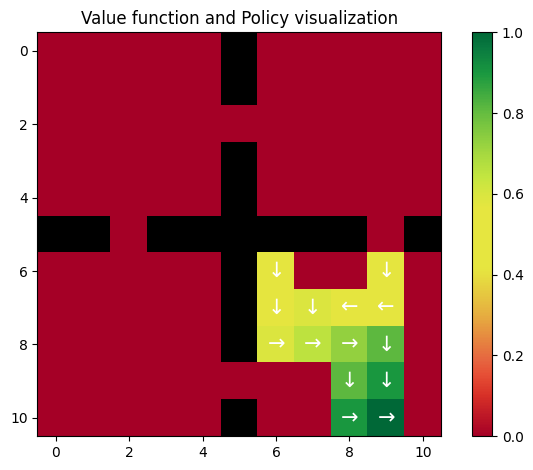

Best Q and action after episode 10:


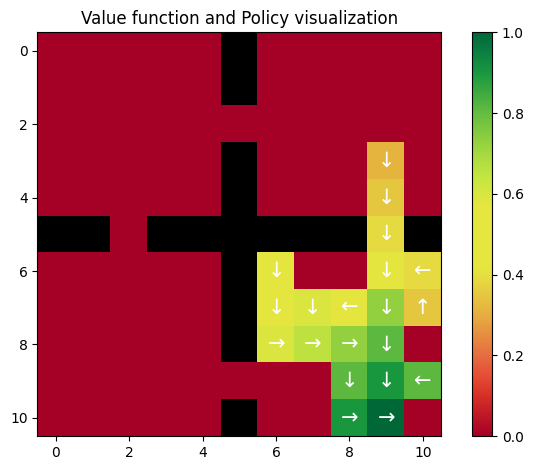

Best Q and action after episode 100:


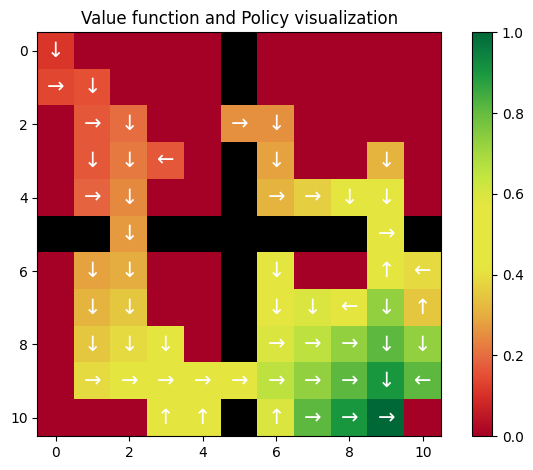

Best Q and action after episode 500:


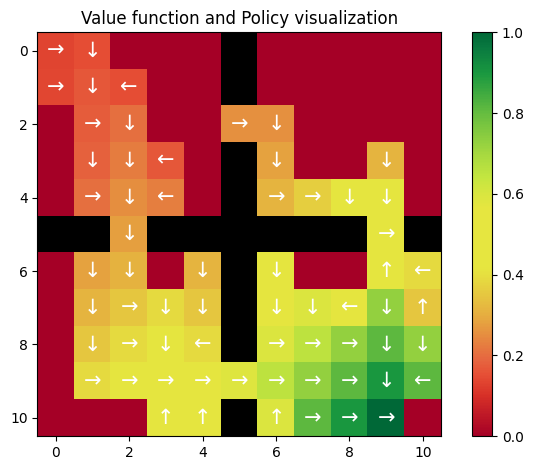

Final Q and policy:


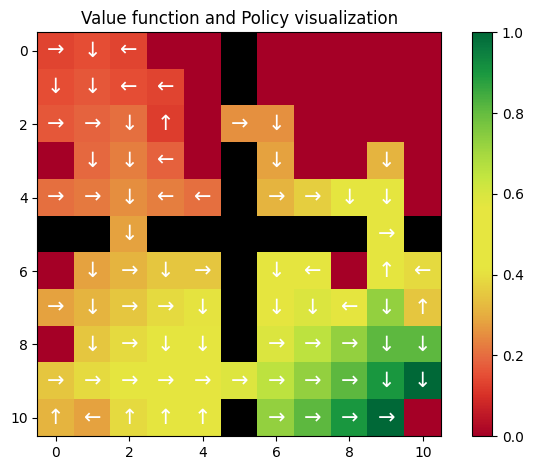

In [135]:
env = FourRoomsEnv()
shapes = (tuple([env.observation_space[i].n for i in range(len(env.observation_space))]), env.action_space.n)
d = {
    'env_shapes': shapes,
    'epsilon': 0.2,
    'gamma': env.gamma,
}
agent = OffMonteCarloIS(**d)
perf_off = view_train_agent(agent, env, 2000)

<span style="color:red"> **TODO** </span>: **Explain** briefly the difference in approach from On to Off policy MC. **Comment** the results you obtained and the evolution of the learnt policy.

(your answer here)